In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")

In [3]:
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'

In [4]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [5]:
psi = 0

In [6]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [7]:
dx = 7.5 
dy = 7.5
dt = 1

In [8]:
depth, rows, cols = eta.shape
gridX, gridY = np.meshgrid(np.arange(1, cols+1), np.arange(1, rows+1))

# Centering and scaling
gridX = (gridX - np.mean(gridX)) * dx
gridY = (gridY - np.mean(gridY)) * dy

# ?? dont really know why youve to rescale the meshgrid of x and y

In [9]:
gridX

array([[-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       ...,
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5]])

In [10]:
gridY

array([[-247.5, -247.5, -247.5, ..., -247.5, -247.5, -247.5],
       [-240. , -240. , -240. , ..., -240. , -240. , -240. ],
       [-232.5, -232.5, -232.5, ..., -232.5, -232.5, -232.5],
       ...,
       [ 232.5,  232.5,  232.5, ...,  232.5,  232.5,  232.5],
       [ 240. ,  240. ,  240. , ...,  240. ,  240. ,  240. ],
       [ 247.5,  247.5,  247.5, ...,  247.5,  247.5,  247.5]])

In [11]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

In [12]:
dk

0.012503851357571316

In [13]:
wavenumbers = np.arange(3 * dk, 0.305, dk)
wavenumbers

# ?? dont know why the wavenumbers are like this 
# ?? can they be changed 

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [14]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1.0, 1.0]
# Ux current limits [m/s]

Uy_limits = [-1.0, 1.0]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

omegaWidthFun = lambda k: 0.05 + 0.0 * k

In [15]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [16]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [17]:
Uxm

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
       [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e

In [18]:
Uym

array([[-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e

# Define Functions

In [19]:
eta.shape

(1200, 67, 67)

In [20]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum

## retrieve_power_spectrum

In [197]:
Nt, Nx, Ny = eta.shape

In [198]:
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)

In [199]:
Kx

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [200]:
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

In [201]:
Ky

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [202]:
len(w)

1200

In [203]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [204]:
for jj in range(len(wavenumbers)):
    wavenumberLimits = wavenumbers[jj] + kW * np.array([-1, 1])

In [205]:
wavenumberLimits = wavenumbers[4] + kW * np.array([-1, 1])

In [206]:
wavenumbers[4]

0.08752695950299921

In [207]:
wavenumberLimits

array([0.07502311, 0.10003081])

In [208]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [209]:
Spectrum = retrieve_power_spectrum(eta, dx, dy, dt, K_limits = wavenumberLimits, W_limits = frequencyLimits)

In [210]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [211]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [212]:
wavenumberLimits[1]

0.10003081086057053

In [213]:
ind_x = np.abs(Kx) <= wavenumberLimits[1]
ind_y = np.abs(Ky) <= wavenumberLimits[1]
ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])

In [359]:
ind_x

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [215]:
ind_y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [216]:
w[ind_w].shape

(598,)

In [217]:
ind_w

array([False, False, False, ...,  True,  True,  True])

In [218]:
Kx[ind_x]

array([-0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081])

In [219]:
W_3D

array([[[0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198],
        [0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198],
        [0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198],
        ...,
        [0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198],
        [0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198],
        [0.01047198, 0.01047198, 0.01047198, ..., 0.01047198,
         0.01047198, 0.01047198]],

       [[0.01570796, 0.01570796, 0.01570796, ..., 0.01570796,
         0.01570796, 0.01570796],
        [0.01570796, 0.01570796, 0.01570796, ..., 0.01570796,
         0.01570796, 0.01570796],
        [0.01570796, 0.01570796, 0.01570796, ..., 0.01570796,
         0.01570796, 0.01570796],
        ...,
        [0.01570796, 0.01570796, 0.01570796, ..., 0.01570796,
         0.01570796, 0.01570796],
        [0.0

In [220]:
# Create 3D structure using meshgrid
W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

In [221]:
Kx_3D.shape

(598, 17, 17)

In [222]:
Ky_3D.shape

(598, 17, 17)

In [223]:
W_3D.shape

(598, 17, 17)

In [224]:
W_3D[0,:,:].shape

(17, 17)

In [225]:
W_3D[:,:,0]

array([[0.01047198, 0.01047198, 0.01047198, ..., 0.01047198, 0.01047198,
        0.01047198],
       [0.01570796, 0.01570796, 0.01570796, ..., 0.01570796, 0.01570796,
        0.01570796],
       [0.02094395, 0.02094395, 0.02094395, ..., 0.02094395, 0.02094395,
        0.02094395],
       ...,
       [3.12588469, 3.12588469, 3.12588469, ..., 3.12588469, 3.12588469,
        3.12588469],
       [3.13112068, 3.13112068, 3.13112068, ..., 3.13112068, 3.13112068,
        3.13112068],
       [3.13635667, 3.13635667, 3.13635667, ..., 3.13635667, 3.13635667,
        3.13635667]])

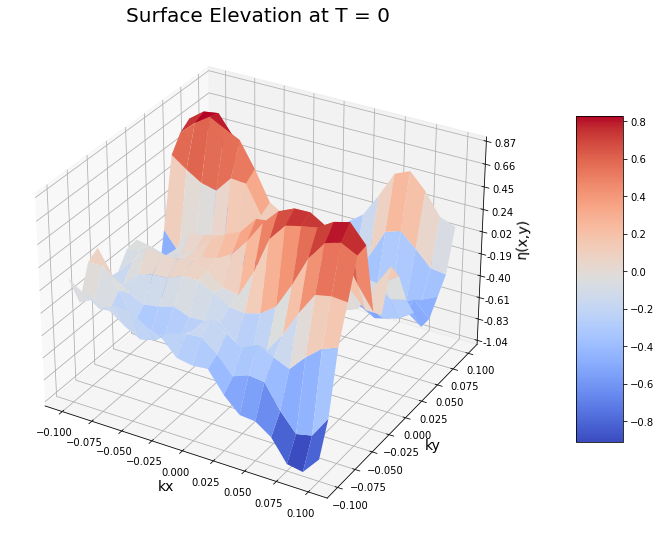

In [226]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Kx_3D[0,:,:], Ky_3D[0,:,:], eta[np.ix_(ind_w, ind_x, ind_y)][0,:,:], cmap=cm.coolwarm)

ax.set_xlabel('kx',fontsize=14)
ax.set_ylabel('ky',fontsize=14)
ax.set_zlabel('η(x,y)',fontsize=14)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=7, location = 'right', pad = 0.1)

plt.title('Surface Elevation at T = 0', fontsize=20)

plt.show()

NameError: name 'power_Spectrum_cut' is not defined

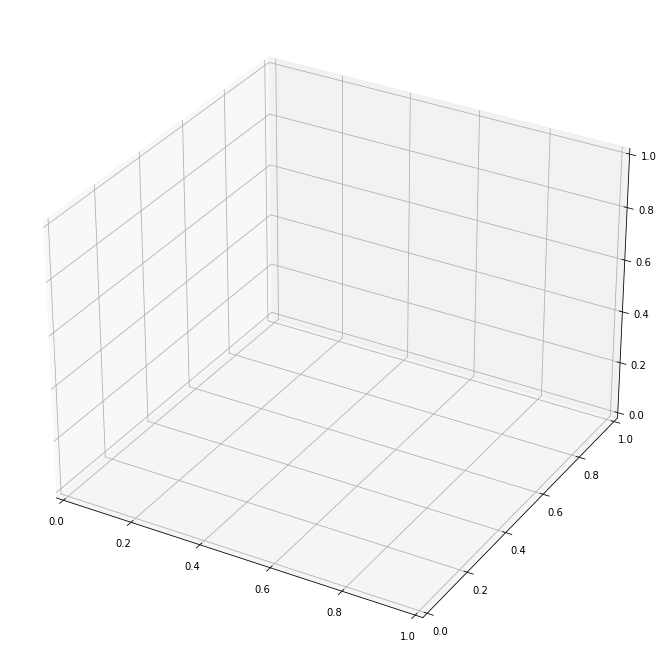

In [227]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Kx_3D[40,:,:], Ky_3D[40,:,:], power_Spectrum_cut[40,:,:], cmap=cm.coolwarm)

ax.set_xlabel('kx',fontsize=14)
ax.set_ylabel('ky',fontsize=14)
ax.set_zlabel('η(x,y)',fontsize=14)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=7, location = 'right', pad = 0.1)

plt.title('Power Spectral Density at T = 0', fontsize=20)

plt.show()

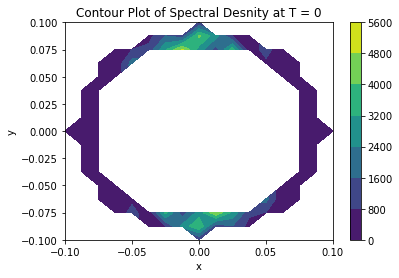

In [240]:
plt.contourf(Kx_3D[0,:,:], Ky_3D[0,:,:], power_Spectrum_cut[0,:,:], cmap='viridis')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of Spectral Desnity at T = 0")

plt.colorbar()

In [241]:
# Set to NaN values outside K_limits
K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < wavenumberLimits[0]) | (K_3D > wavenumberLimits[1])] = np.nan

In [242]:
wavenumberLimits

array([0.07502311, 0.10003081])

In [243]:
K_3D

array([[[0.14146493, 0.13291776, 0.12503851, ..., 0.12503851,
         0.13291776, 0.14146493],
        [0.13291776, 0.12378181, 0.11527981, ..., 0.11527981,
         0.12378181, 0.13291776],
        [0.12503851, 0.11527981, 0.1060987 , ..., 0.1060987 ,
         0.11527981, 0.12503851],
        ...,
        [0.12503851, 0.11527981, 0.1060987 , ..., 0.1060987 ,
         0.11527981, 0.12503851],
        [0.13291776, 0.12378181, 0.11527981, ..., 0.11527981,
         0.12378181, 0.13291776],
        [0.14146493, 0.13291776, 0.12503851, ..., 0.12503851,
         0.13291776, 0.14146493]],

       [[0.14146493, 0.13291776, 0.12503851, ..., 0.12503851,
         0.13291776, 0.14146493],
        [0.13291776, 0.12378181, 0.11527981, ..., 0.11527981,
         0.12378181, 0.13291776],
        [0.12503851, 0.11527981, 0.1060987 , ..., 0.1060987 ,
         0.11527981, 0.12503851],
        ...,
        [0.12503851, 0.11527981, 0.1060987 , ..., 0.1060987 ,
         0.11527981, 0.12503851],
        [0.1

In [244]:
# Get original spectrum limits
Kx_orig_limits = [Kx[0], Kx[-1]]
Ky_orig_limits = [Ky[0], Ky[-1]]
W_orig_limits = [w[0], w[-1]]

In [245]:
power_Spectrum_cut.shape

(598, 17, 17)

In [246]:
np.nanmax(power_Spectrum_cut)

1488046508.344682

In [247]:
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [248]:
np.nanmax(power_Spectrum_cut)

0.03772334003357943

In [249]:
power_Spectrum_cut

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

## get_doppler_shift_velocities_nsp

In [250]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    if not verboseFig:
        verboseFig = 0

    if 'include2ndHarmonic' not in fit_param:
        fit_param['include2ndHarmonic'] = 0

    if 'logFlag' not in fit_param:
        fit_param['logFlag'] = 0

    if 'SNR_filter' not in fit_param:
        fit_param['SNR_filter'] = 0

    if 'SNR_threshold' not in fit_param:
        fit_param['SNR_threshold'] = 2.0

    if 'Peak_filter' not in fit_param:
        fit_param['Peak_filter'] = 0

    if 'Peak_threshold' not in fit_param:
        fit_param['Peak_threshold'] = 0.5

    if 'Outlier_filter' not in fit_param:
        fit_param['Outlier_filter'] = 0

    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    if fit_param['SNR_filter']:
        SNR_inds = out_fit['SNR_max'] > fit_param['SNR_threshold']
        out_fit['Ux_filt'][~SNR_inds] = np.nan
        out_fit['Uy_filt'][~SNR_inds] = np.nan

    if fit_param['Peak_filter']:
        indsMultPeaks = peak_filter(out_fit['verbose'], fit_param['Peak_threshold'])
        out_fit['Ux_filt'][indsMultPeaks] = np.nan
        out_fit['Uy_filt'][indsMultPeaks] = np.nan

    if fit_param['Outlier_filter']:
        indsX_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Ux_filt'])
        indsY_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Uy_filt'])
        out_fit['Ux_filt'][~indsX_keep] = np.nan
        out_fit['Uy_filt'][~indsY_keep] = np.nan

    return out_fit


# Peak filter. Returns indices where there are multiple peaks in the SNR_2D field exceeding a threshold value.
def peak_filter(S, peak_thresh):
    inds_multiple_peaks = np.zeros(len(S), dtype=bool)

    for i in range(len(S)):
        peak_vals = S[i]['SNR_2D'][S[i]['Peaks_2D']]
        inds_multiple_peaks[i] = np.sum(peak_vals / np.max(peak_vals) > peak_thresh) > 1

    return inds_multiple_peaks


# Filter based on quartiles
def quartile_filter(x, y):
    inds_nan = np.isnan(y)

    x = x[~inds_nan]
    y = y[~inds_nan]

    pct = np.polyfit(x, y, 1)
    delCtil = y - np.polyval(pct, x)
    delCtil_srt = np.sort(delCtil)

    Q1 = np.median(delCtil_srt[:round(len(delCtil_srt) / 2)])
    Q3 = np.median(delCtil_srt[round(len(delCtil_srt) / 2):])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    inds_keep = np.logical_and(delCtil > lower_fence, delCtil < upper_fence)

    inds_outlier = np.ones(inds_nan.shape, dtype=bool)
    inds_outlier[~inds_nan] = inds_keep

    return inds_outlier

In [251]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    
    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers)}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    return out_fit



In [252]:
Ux_2D = Uxm
Uy_2D = Uym

In [253]:
Ux_2D

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
       [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e

In [254]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [255]:
Ux = np.zeros(len(wavenumbers))
Uy = np.zeros(len(wavenumbers))

In [256]:
Ux

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [257]:
SNR_max = np.zeros(len(wavenumbers))

In [258]:
omegaWidthFun
# just equals 0.05

<function __main__.<lambda>(k)>

In [259]:
omegaWidthFun(wavenumbers)

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [260]:
snrG = np.zeros(Ux_2D.shape)

In [261]:
snrG.shape

(21, 21)

In [262]:
fit_param = {'wavenumbers': 0.3000924325817116,
 'include2ndHarmonic': 0,
 'logFlag': [],
 'SNR_filter': 0,
 'SNR_threshold': 1.0,
 'Peak_filter': 0,
 'Peak_threshold': 0.5,
 'Outlier_filter': 0,
 'kWidth': 0.050015405430285265,
 'Ux_2D': np.array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
        [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
         -8.00000000e-01, -8.00000000e-01, -8.00000000e-01],
        [-7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01,
         -7.00000000e-01, -7.00000000e-01, -7.00000000e-01],
        [-6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01,
         -6.00000000e-01, -6.00000000e-01, -6.00000000e-01],
        [-5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
         -5.00000000e-01, -5.00000000e-01, -5.00000000e-01],
        [-4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01,
         -4.00000000e-01, -4.00000000e-01, -4.00000000e-01],
        [-3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01,
         -3.00000000e-01, -3.00000000e-01, -3.00000000e-01],
        [-2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01,
         -2.00000000e-01, -2.00000000e-01, -2.00000000e-01],
        [-1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01,
         -1.00000000e-01, -1.00000000e-01, -1.00000000e-01],
        [-2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
         -2.22044605e-16, -2.22044605e-16, -2.22044605e-16],
        [ 1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01,
          1.00000000e-01,  1.00000000e-01,  1.00000000e-01],
        [ 2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
          2.00000000e-01,  2.00000000e-01,  2.00000000e-01],
        [ 3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01,
          3.00000000e-01,  3.00000000e-01,  3.00000000e-01],
        [ 4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
          4.00000000e-01,  4.00000000e-01,  4.00000000e-01],
        [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
          5.00000000e-01,  5.00000000e-01,  5.00000000e-01],
        [ 6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01,
          6.00000000e-01,  6.00000000e-01,  6.00000000e-01],
        [ 7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01,
          7.00000000e-01,  7.00000000e-01,  7.00000000e-01],
        [ 8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01,
          8.00000000e-01,  8.00000000e-01,  8.00000000e-01],
        [ 9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01,
          9.00000000e-01,  9.00000000e-01,  9.00000000e-01],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 'Uy_2D': np.array([[-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
        [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
         -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
         -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
         -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
          2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
          5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
          8.00000000e-01,  9.00000000e-01,  1.00000000e+00]])}

In [263]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [264]:
P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}

In [265]:
snrG = np.zeros(fit_param['Ux_2D'].shape)

In [266]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [267]:
for i in range(fit_param['Ux_2D'].shape[0]):
    for j in range(fit_param['Ux_2D'].shape[1]):
        snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers[4], fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
        snrG[i, j] = snr_ij

In [268]:
wavenumbers[4]

0.08752695950299921

In [269]:
snrG.shape

(21, 21)

In [270]:
snrG

array([[ 7.70023986,  8.7059145 ,  9.93257861, 11.41799895, 13.15689   ,
        15.07106818, 16.99510176, 18.69108085, 19.89791531, 20.40390898,
        20.11380407, 19.07764638, 17.46706662, 15.51444927, 13.44818447,
        11.44999001,  9.63984125,  8.07978984,  6.78611942,  5.74354721,
         4.91871314],
       [ 7.61866569,  8.62367404,  9.86859686, 11.39873926, 13.21106481,
        15.22200711, 17.25347011, 19.0510137 , 20.33792638, 20.89082713,
        20.60694386, 19.53305562, 17.8438376 , 15.78289675, 13.59631667,
        11.48487493,  9.5835842 ,  7.96239375,  6.63802371,  5.58989419,
         4.77636343],
       [ 7.53754692,  8.54026207,  9.8010082 , 11.37161156, 13.25064422,
        15.34931401, 17.4780268 , 19.36797982, 20.72953235, 21.32960754,
        21.05778487, 19.95511881, 18.19613419, 16.03373961, 13.73172932,
        11.51103939,  9.5226985 ,  7.84482452,  6.4942324 ,  5.44446928,
         4.64512431],
       [ 7.4623944 ,  8.46216924,  9.73675647, 11.3431398 

In [271]:
im = np.argmax(snrG)
# gets the index of maximum value of when its a 1d array

In [272]:
im

135

In [273]:
if np.ndim(Ux_2D) == 1:
    cDoppGuess = Ux_2D[im]
else:
    Ux_1D = Ux_2D.flatten()
    Uy_1D = Uy_2D.flatten()
    cDoppGuess = [Ux_1D[im], Uy_1D[im]]

In [274]:
cDoppGuess

[-0.40000000000000013, -0.1000000000000002]

In [275]:
Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] 
                if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], 
                                                                        U[0], U[1])[0], cDoppGuess)

In [276]:
Ufit

      fun: -15.12942593719865
 hess_inv: array([[ 0.09592007, -0.00329744],
       [-0.00329744,  0.0141455 ]])
      jac: array([-3.81469727e-06, -4.29153442e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-0.365201  , -0.00519632])

In [277]:
if len(cDoppGuess) > 1:
    Ufit = Ufit.x
else:
    Ufit = [Ufit.x[0], 0]

In [278]:
Ufit

array([-0.365201  , -0.00519632])

In [279]:
Ux = Ufit[0]
Uy = Ufit[1]

In [280]:
Ux

-0.3652009989818383

In [281]:
Uy

-0.005196324194512281

In [282]:
## These are values for k = 0.3 ish 

In [283]:
nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], -0.3652007913488268, -0.00519622778470467)[0]

16.129425937199336

## nsp_doppler_shift_extraction

In [284]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [285]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [286]:
U = Ux_2D[0,0]
V = Uy_2D[0,0]

In [287]:
omegaFun = lambda kx, ky: np.sqrt((g*np.sqrt(kx**2 + ky**2) + T*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * h))+ U*kx + V*ky


In [288]:
omegaFun

<function __main__.<lambda>(kx, ky)>

In [289]:
omegaWidth = omegaWidthFun(wavenumbers)

In [290]:
a = omegaWidth

In [291]:
kWidth = 0.050015405430285265

In [292]:
a_k = kWidth

In [293]:
# Use np.ix_ for boolean indexing to extract the desired values
power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

In [294]:
K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < wavenumberLimits[0]) | (K_3D > wavenumberLimits[1])] = np.nan

In [295]:
K_3D.shape

(598, 17, 17)

In [296]:
power_Spectrum_cut.shape

(598, 17, 17)

In [297]:
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [298]:
power_Spectrum_cut.shape

(598, 17, 17)

In [299]:
inds = ~np.isnan(power_Spectrum_cut)

In [300]:
inds

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [301]:
inds.shape

(598, 17, 17)

In [302]:
inds

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [303]:
power_Spectrum_cut

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [304]:
P_k = np.sqrt(power_Spectrum_cut[inds])
KX = Kx_3D[inds]
KY = Ky_3D[inds]
W = W_3D[inds]

In [305]:
result = np.sqrt( np.where(inds, power_Spectrum_cut, np.nan) )

In [306]:
result.shape

(598, 17, 17)

In [307]:
result[~np.isfinite(result)] = 0

In [308]:
KX_result = np.where(inds, Kx_3D, np.nan)
KY_result = np.where(inds, Ky_3D, np.nan)
W_result = np.where(inds, W_3D, np.nan)

In [309]:
KX_result[~np.isfinite(KX_result)] = 0
KY_result[~np.isfinite(KY_result)] = 0
W_result[~np.isfinite(W_result)] = 0

In [310]:
result.shape

(598, 17, 17)

In [311]:
KX_result.shape

(598, 17, 17)

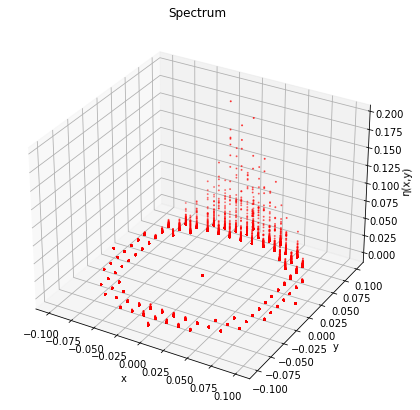

In [312]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(KX_result, KY_result, result, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')
 
# show plot
plt.show()

In [313]:
P_k

array([5.33973930e-06, 1.85342482e-05, 1.57824259e-05, ...,
       5.86548848e-06, 7.59520982e-06, 1.99094303e-06])

In [314]:
KX

array([-0.10003081, -0.08752696, -0.08752696, ...,  0.08752696,
        0.08752696,  0.10003081])

In [315]:
KY

array([ 0.        , -0.03751155, -0.0250077 , ...,  0.0250077 ,
        0.03751155,  0.        ])

In [316]:
W

array([0.01047198, 0.01047198, 0.01047198, ..., 3.13635667, 3.13635667,
       3.13635667])

In [317]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

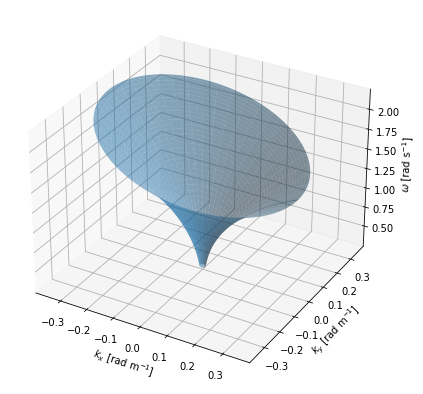

In [318]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=100, z=z, U=U, psi=0)

In [319]:
wavenumbers[4]

0.08752695950299921

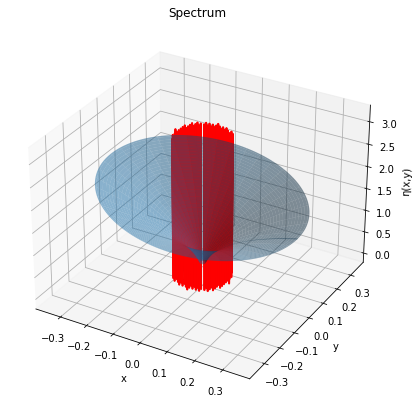

In [320]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

kx, ky, ww, kk, th = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0)
 
# Creating plot
ax.scatter3D(KX, KY, W, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')
 
# show plot
plt.show()

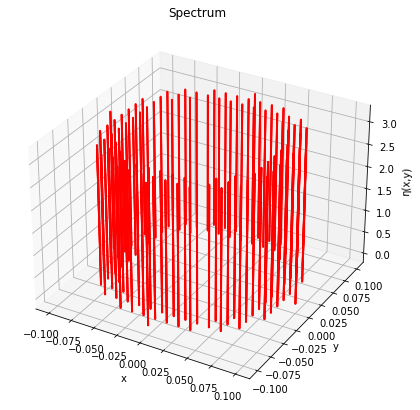

In [321]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(KX, KY, W, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')
 
# show plot
plt.show()

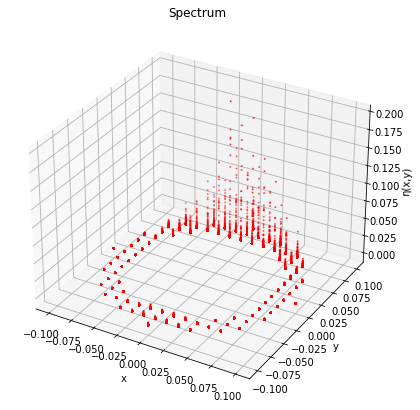

In [322]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(KX, KY, P_k, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')
 
# show plot
plt.show()

In [323]:
U

-1.0

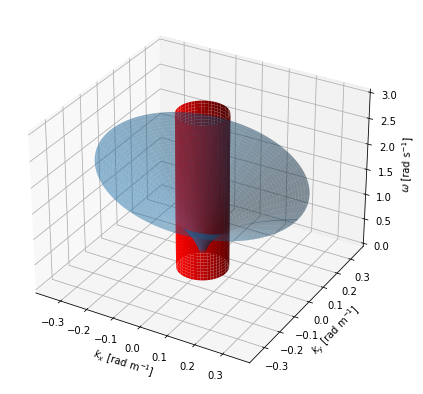

In [324]:
# Define the cylinder parameters
radius = 0.08752695950299921  
height = 3  

# Create data for the cylinder
theta = np.linspace(0, 2 * np.pi, 1000)
z_cylinder = np.linspace(0, height, 1000)
theta, z_cylinder = np.meshgrid(theta, z_cylinder)
x_cylinder = radius * np.cos(theta)
y_cylinder = radius * np.sin(theta)

# plot surface
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=1000, z=z, U=U, psi=0)

# Plot cylinder
axes.plot_surface(x_cylinder, y_cylinder, z_cylinder, color='red', alpha=1)

plt.show()


# Intersection Between Surfaces

In [325]:
def plot_disp_surf_at_angle(spec_theta, h, z, U, psi):

# (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww, kk, th = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]

    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation at $\Theta$")
    plt.legend()
    
    return kx, ky, disp_r,disp_ww_for_theta

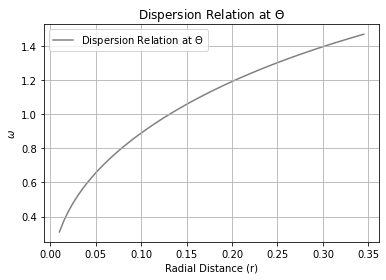

In [326]:
kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(0, h = 1000, z=z, U=U, psi = 0)

In [327]:
wavenumbers[4]

0.08752695950299921

In [328]:
y_interpolated = np.interp( wavenumbers[4], disp_r, disp_ww_for_theta)
y_interpolated

0.8400479179921626

In [329]:
angles_list = np.linspace(- np.pi,  np.pi, 100)

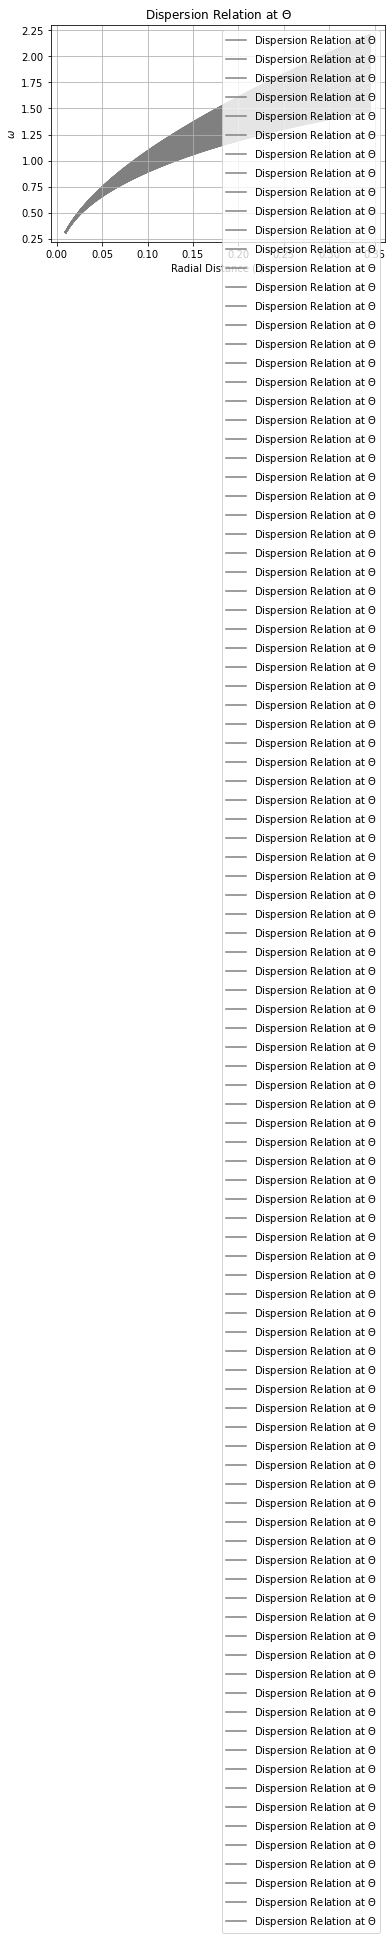

In [330]:
intersection_w_values = []

for i in range(len(angles_list)):
    kx, ky, disp_r, disp_ww_for_theta = plot_disp_surf_at_angle(angles_list[i], h = 1000, z=z, U=U, psi = 0)
    
    w_interpolate = np.interp( wavenumbers[4], disp_r, disp_ww_for_theta)
    
    intersection_w_values.append(w_interpolate)


Text(0.5, 1.0, 'Intersection surface')

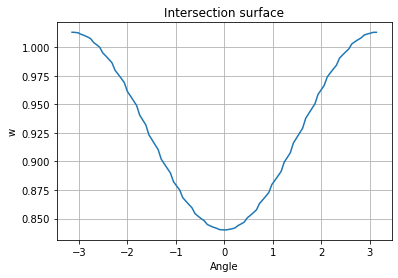

In [331]:
plt.plot(angles_list, intersection_w_values)
plt.grid(True)
plt.xlabel("Angle")
plt.ylabel("w")

plt.title("Intersection surface")

In [332]:
intersection_w_values

[1.013015973822416,
 1.0128715530903742,
 1.0125113321250416,
 1.0111476280915135,
 1.0101475535731983,
 1.0089384874017537,
 1.0075234516129392,
 1.004090124569829,
 1.002080414845099,
 0.9998818771127755,
 0.994940756659308,
 0.992210524166012,
 0.9893161332516802,
 0.9862648183862289,
 0.9797222967596264,
 0.9762474428952621,
 0.9726483299996271,
 0.9689339539805786,
 0.9611968134873946,
 0.9571933878350671,
 0.9531133283659594,
 0.9489668331038902,
 0.94051613166576,
 0.936233047842254,
 0.9319257201360158,
 0.9232814310670505,
 0.918966075925137,
 0.914669635337819,
 0.9104028481690214,
 0.902000792295863,
 0.8978865243554791,
 0.8938438588705964,
 0.8898829003995475,
 0.882245476861693,
 0.8785881013762387,
 0.8750505643533092,
 0.868370052061858,
 0.8652437745949215,
 0.862270689457872,
 0.8594582278151994,
 0.8543428747249577,
 0.8520527689960897,
 0.849948826241363,
 0.8480363052219522,
 0.8448041592122609,
 0.8434926129037358,
 0.8423886255015396,
 0.8414949563992323,
 0.8403

In [333]:
kx.shape

(68, 127)

In [334]:
ww.shape

(68, 127)

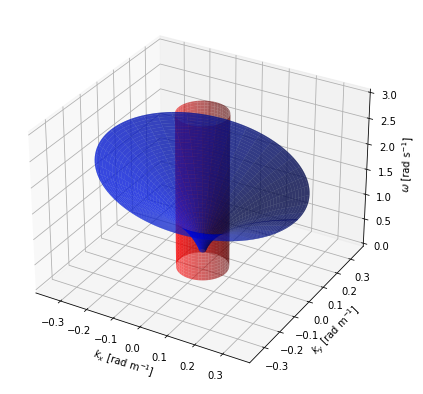

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the cylinder parameters
radius = 0.08752695950299921  # You can set your desired radius
height = 3  # You can set your desired height

# Create data for the cylinder
theta = np.linspace(0, 2 * np.pi, 100)
z_cylinder = np.linspace(0, height, 100)
theta, z_cylinder = np.meshgrid(theta, z_cylinder)
x_cylinder = radius * np.cos(theta)
y_cylinder = radius * np.sin(theta)

# Your existing code
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')
kx, ky, ww, kk, th = plot_disp_shell(axes, h=1000, z=z, U=U, psi=0)

# Plot the cylinder
cylinder_surface = axes.plot_surface(x_cylinder, y_cylinder, z_cylinder, color='red', alpha=0.6)

# Plot the intersection between the two surfaces
intersection_surface = axes.plot_surface(kx, ky, ww, color='blue', alpha=0.6)

# Show the plot
plt.show()


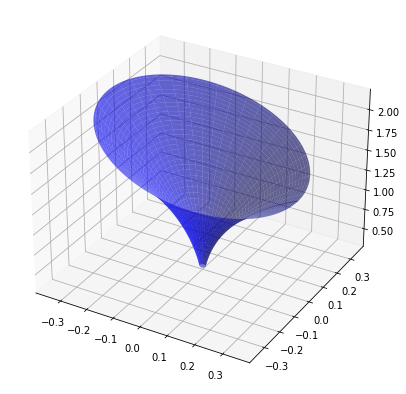

In [336]:
# Your existing code
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')

# Plot the intersection between the two surfaces
intersection_surface = axes.plot_surface(kx, ky, ww, color='blue', alpha=0.6)

# Show the plot
plt.show()

In [337]:
P_k2 = 0

In [338]:
K = np.sqrt(KX**2 + KY**2)
order = 2

In [339]:
K

array([0.10003081, 0.09522649, 0.09102941, ..., 0.09102941, 0.09522649,
       0.10003081])

In [340]:
a_k

0.050015405430285265

In [341]:
np.isnan(wavenumbers)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [342]:
a_k

0.050015405430285265

In [343]:
P_k.shape

(52624,)

In [344]:
K.shape

(52624,)

In [345]:
np.isnan(wavenumbers)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [346]:
P_k = P_k * np.exp( -2 * ( ( K - wavenumbers[4] ) / np.max(a_k) ) **2  )

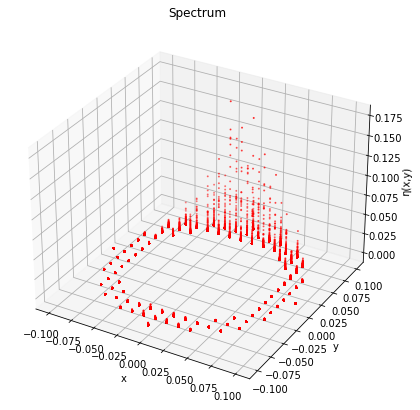

In [347]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(KX, KY, P_k, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')
 
# show plot
plt.show()

In [348]:
max(P_k)

0.17483655542024795

In [349]:
# Define weighting function G
G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

G = G1 + G2

In [350]:
omegaFun(KX, KY)

array([1.09063786, 1.09156424, 1.05752069, ..., 0.83245136, 0.84148721,
       0.89057624])

In [351]:
G

array([8.34175705e-283, 6.59600130e-253, 1.38087331e-247, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [352]:
P_k[~np.isfinite(P_k)] = 0

In [353]:
InP = P_k * G

In [354]:
signal_1 = np.sum(InP)/np.sum(G)

In [355]:
noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)

In [356]:
SNR = signal_1 /noise_1

In [357]:
SNR

7.700239858216069

# Full Function

In [167]:
wavenumberLimits = []

for jj in range(len(wavenumbers)):
    wavenumberLimits_range = wavenumbers[jj] + kW * np.array([-1,1])
    wavenumberLimits.append(wavenumberLimits_range)

In [168]:
wavenumberLimits
# each wavenumber has a range 

[array([0.0250077 , 0.05001541]),
 array([0.03751155, 0.06251926]),
 array([0.05001541, 0.07502311]),
 array([0.06251926, 0.08752696]),
 array([0.07502311, 0.10003081]),
 array([0.08752696, 0.11253466]),
 array([0.10003081, 0.12503851]),
 array([0.11253466, 0.13754236]),
 array([0.12503851, 0.15004622]),
 array([0.13754236, 0.16255007]),
 array([0.15004622, 0.17505392]),
 array([0.16255007, 0.18755777]),
 array([0.17505392, 0.20006162]),
 array([0.18755777, 0.21256547]),
 array([0.20006162, 0.22506932]),
 array([0.21256547, 0.23757318]),
 array([0.22506932, 0.25007703]),
 array([0.23757318, 0.26258088]),
 array([0.25007703, 0.27508473]),
 array([0.26258088, 0.28758858]),
 array([0.27508473, 0.30009243]),
 array([0.28758858, 0.31259628])]

In [169]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [170]:
Spectrum_at_k = []

ind_x_at_k = []
ind_y_at_k = []
ind_w_at_k = []

W_3D_at_k = []
Kx_3D_at_k = []
Ky_3D_at_k = []

Ux_at_k = []
Uy_at_k = []

SNR_max_at_k = []

snrG_at_k = []

im_at_k = []
cDoppGuess_at_k = []

Ux_at_k_correct = []
Uy_at_k_correct = []

# Initialize the tqdm progress bar outside the loop
progress_bar = tqdm(total=len(wavenumberLimits), desc="Processing wavenumbers")

for i in range(len(wavenumberLimits)):
    # i is the index of each wavenumber
    
    Spectrum = retrieve_power_spectrum(eta, dx, dy, dt, K_limits=wavenumberLimits[i], W_limits=frequencyLimits)
    Spectrum_at_k.append(Spectrum)
    
    Nt, Nx, Ny = eta.shape
    
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values
    # w = spec3d.get_C()[0]
    # Kx = spec3d.get_C()[1]
    # Ky = spec3d.get_C()[2]
    
    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    # kx, ky and w resolution
    
    Norm = dKx * dKy * dW
    
    # Get power spectra (1200, 67, 67)
    Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2
    # ?? how is this related to FFT spec3d.spectrum()
    
    ind_x = np.abs(Kx) <= wavenumberLimits[i][1]
    ind_x_at_k.append(ind_x)
    ind_y = np.abs(Ky) <= wavenumberLimits[i][1]
    ind_y_at_k.append(ind_y)
    # Is the absolute values of Kx and Ky smaller than the upper value of the wavenumber range 
    
    ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    ind_w_at_k.append(ind_w)
    # Is the value of w between the frequency limits 0.01 and 20 
    
    # Create 3D structure where it only includes w,Kx,Ky that are in the ranges required by wavenumberLimits
    W_3D, Kx_3D, Ky_3D = np.meshgrid( w[ind_w_at_k[i]], Kx[ind_x_at_k[i]] , Ky[ind_y_at_k[i]] , indexing='ij')
    W_3D_at_k.append(W_3D)
    Kx_3D_at_k.append(Kx_3D)
    Ky_3D_at_k.append(Ky_3D)
    
    
    Ux_2D = Uxm
    Uy_2D = Uym
    
    snrG = np.zeros(Ux_2D.shape)
    
    for m in range(Ux_2D.shape[0]):
        for n in range(Ux_2D.shape[1]):
            snr_mn, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers[i], Ux_2D[m, n], Uy_2D[m, n])
            snrG[m, n] = snr_mn
            
            
    snrG_at_k.append(snrG)
    # Append the 2D array to the list
    
    
    im = np.argmax(snrG_at_k[i])
    im_at_k.append(im)
    
    if np.ndim(Ux_2D) == 1:
        cDoppGuess = Ux_2D[im]
    else:
        Ux_1D = Ux_2D.flatten()
        Uy_1D = Uy_2D.flatten()
        cDoppGuess = [Ux_1D[im], Uy_1D[im]]
    
    cDoppGuess_at_k.append(cDoppGuess)
    
    
    Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], cDoppGuess)
    
    Ux = Ufit.x[0]
    Uy = Ufit.x[1]
    
    Ux_at_k_correct.append(Ux)
    Uy_at_k_correct.append(Uy)
    
    # Update the tqdm progress bar
    progress_bar.update(1)

# Close the tqdm progress bar after the loop is finished
progress_bar.close()

Processing wavenumbers: 100%|██████████| 22/22 [06:57<00:00, 18.98s/it]


In [171]:
Ux = np.array(Ux_at_k_correct)
Uy = np.array(Uy_at_k_correct)

(0.0, 0.31)

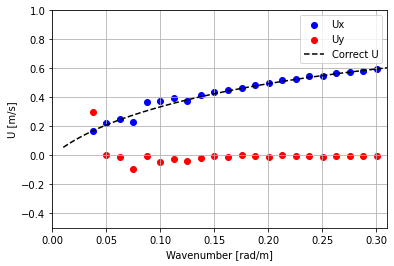

In [172]:
plt.scatter(wavenumbers, -Ux, label='Ux', color = 'blue')
plt.scatter(wavenumbers, Uy, label='Uy', color = 'red')
plt.plot(k, Uk[:,0], label = 'Correct U', linestyle='--', color='black')


plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")

plt.ylim(-0.5, 1)
plt.xlim(0, 0.31)

# Figure 5 Intersection surface power

In [555]:
wavenumberLimits = []

for jj in range(len(wavenumbers)):
    wavenumberLimits_range = wavenumbers[jj] + kW * np.array([-1,1])
    wavenumberLimits.append(wavenumberLimits_range)

In [556]:
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[0,:,:])
    Ky_2D = np.squeeze(Ky_3D[0,:,:])
    W_1D = np.squeeze(W_3D[:,0,0])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi + dtheta, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut.T * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

#### ALso need to change [] below

In [531]:
dtheta = 2*dk / wavenumbers[20]

In [557]:
ind_x = np.abs(Kx) <= wavenumberLimits[20][1]
ind_y = np.abs(Ky) <= wavenumberLimits[20][1]
ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    
W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')
    
    # Use np.ix_ for boolean indexing to extract the desired values
power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
power_Spectrum_cut[(K_3D < wavenumberLimits[20][0]) | (K_3D > wavenumberLimits[20][1])] = np.nan
    
power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

In [558]:
Scyl = cylinder_cross_section( Spectrum , dtheta , power_Spectrum_cut, 4 );

In [571]:
def plot_figure_5(m):
    ind_x = np.abs(Kx) <= wavenumberLimits[m][1]
    ind_y = np.abs(Ky) <= wavenumberLimits[m][1]
    ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')
    
    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < wavenumberLimits[m][0]) | (K_3D > wavenumberLimits[m][1])] = np.nan
    
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)
    
    dtheta = 2*dk / wavenumbers[m]
    theta_vals = np.arange(-np.pi, np.pi + dtheta, dtheta)
    
    Scyl = cylinder_cross_section( Spectrum , dtheta , power_Spectrum_cut, 4 );
    
    thetaVals = Scyl['thetaM'][0, :] / np.pi 
    omegaM_values = Scyl['omegaM'][:, 0]

    # Plotting
    plt.imshow( Scyl['P_k'] , extent=[min(thetaVals) , max(thetaVals)  , min(omegaM_values), max(omegaM_values)],
          aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    
    plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * wavenumbers[m]) + 0 * thetaVals, linestyle=':', color='r', linewidth=1.5)
    plt.plot(thetaVals , np.sqrt(1) * np.sqrt(9.81 * wavenumbers[m]) + wavenumbers[m] * (np.cos(thetaVals) * Ux + np.sin(thetaVals) * Uy),
         linestyle='--', color='r', linewidth=1.5)

    plt.show()
    
    return Scyl

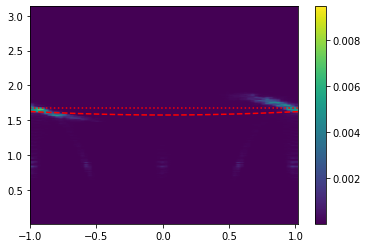

{'P_k': array([[2.71604321e-07, 1.12896892e-07, 9.30450109e-08, ...,
         6.23843128e-08, 2.72483206e-07, 1.90590511e-07],
        [2.72502478e-07, 1.13123037e-07, 9.33977728e-08, ...,
         6.27068657e-08, 2.73481335e-07, 1.91029930e-07],
        [2.73446172e-07, 1.13362970e-07, 9.37580737e-08, ...,
         6.30382034e-08, 2.74524972e-07, 1.91496580e-07],
        ...,
        [6.56869775e-08, 6.59396518e-08, 6.45828815e-08, ...,
         3.73441474e-08, 6.38750121e-08, 7.54252426e-08],
        [6.53334443e-08, 6.55998187e-08, 6.42087910e-08, ...,
         3.71275446e-08, 6.35178297e-08, 7.50206712e-08],
        [6.49842610e-08, 6.52637230e-08, 6.38389447e-08, ...,
         3.69133375e-08, 6.31650136e-08, 7.46207150e-08]]),
 'thetaM': array([[-3.14159265, -3.05463613, -2.96767961, ...,  3.03232039,
          3.11927691,  3.20623343],
        [-3.14159265, -3.05463613, -2.96767961, ...,  3.03232039,
          3.11927691,  3.20623343],
        [-3.14159265, -3.05463613, -2.967679

In [572]:
plot_figure_5(20)

# Triplet Method

In [173]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [174]:
spec3d

In [175]:
spec3d.get_C()

(array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
         3.13112068,  3.13635667]),
 array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
        -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
        -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
        -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
        -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
        -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
        -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
         0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
         0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
         0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
         0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
         0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
         0.3427192 ,  0

In [176]:
w = spec3d.get_C()[0]

In [177]:
Kx = spec3d.get_C()[1]

In [178]:
Ky = spec3d.get_C()[2]

In [179]:
Ky

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [180]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [181]:
dKx

0.012693303650867849

In [182]:
dKy

0.012693303650867849

In [183]:
dW

0.005235987755983107

In [184]:
Norm = dKx * dKy * dW

In [185]:
Norm

8.436221250974528e-07

In [186]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [187]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [188]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [189]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [190]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [191]:
spec3d.spectrum()

array([[[8.08448245e-11, 8.04448126e-11, 7.92351793e-11, ...,
         7.69202100e-11, 7.92351793e-11, 8.04448126e-11],
        [8.26274044e-11, 8.40336723e-11, 8.45450464e-11, ...,
         7.23470679e-11, 7.69223490e-11, 8.02539750e-11],
        [8.80727465e-11, 9.15182353e-11, 9.42511780e-11, ...,
         7.09461490e-11, 7.84368641e-11, 8.38550234e-11],
        ...,
        [9.84704564e-11, 9.17370404e-11, 8.38289587e-11, ...,
         1.15278037e-10, 1.09487819e-10, 1.04127689e-10],
        [8.80727465e-11, 8.38550234e-11, 7.84368641e-11, ...,
         9.70534669e-11, 9.42511780e-11, 9.15182353e-11],
        [8.26274044e-11, 8.02539750e-11, 7.69223490e-11, ...,
         8.47510660e-11, 8.45450464e-11, 8.40336723e-11]],

       [[8.08462498e-11, 8.03595031e-11, 7.89924959e-11, ...,
         7.70103267e-11, 7.92111792e-11, 8.04171168e-11],
        [8.25437908e-11, 8.39926166e-11, 8.48110586e-11, ...,
         7.26312032e-11, 7.71373859e-11, 8.03995746e-11],
        [8.82164605e-11, 

In [192]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [193]:
Norm

8.436221250974528e-07

In [194]:
dKx*dKy*dW

8.436221250974528e-07

In [195]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [196]:
power_Spectrum

array([[[0.00037927, 0.00038411, 0.00039617, ..., 0.0003978 ,
         0.00038556, 0.00037973],
        [0.00039525, 0.00039994, 0.00041026, ..., 0.0004174 ,
         0.00040297, 0.00039589],
        [0.00043181, 0.0004353 , 0.00044659, ..., 0.00045827,
         0.0004423 , 0.00043377],
        ...,
        [0.00043377, 0.0004423 , 0.00045827, ..., 0.00044659,
         0.0004353 , 0.00043181],
        [0.00039589, 0.00040297, 0.0004174 , ..., 0.00041026,
         0.00039994, 0.00039525],
        [0.00037973, 0.00038556, 0.0003978 , ..., 0.00039617,
         0.00038411, 0.00037927]],

       [[0.00038002, 0.00038504, 0.00039576, ..., 0.0003974 ,
         0.00038557, 0.00037967],
        [0.00039506, 0.00039921, 0.00041095, ..., 0.0004162 ,
         0.00040335, 0.00039631],
        [0.00043106, 0.00043526, 0.00044596, ..., 0.00045773,
         0.00044169, 0.00043376],
        ...,
        [0.00043476, 0.00044321, 0.00045864, ..., 0.00044642,
         0.00043567, 0.00043197],
        [0.0

In [127]:
np.sqrt ( spec3d.spectrum() ) * Norm * np.prod(eta.shape) 

array([[[4.08606173e-05, 4.07594049e-05, 4.04517985e-05, ...,
         3.98564894e-05, 4.04517985e-05, 4.07594049e-05],
        [4.13086372e-05, 4.16586780e-05, 4.17852395e-05, ...,
         3.86535405e-05, 3.98570436e-05, 4.07110299e-05],
        [4.26480896e-05, 4.34743033e-05, 4.41186491e-05, ...,
         3.82774701e-05, 4.02475014e-05, 4.16143729e-05],
        ...,
        [4.50953527e-05, 4.35262423e-05, 4.16079049e-05, ...,
         4.87923908e-05, 4.75512255e-05, 4.63726514e-05],
        [4.26480896e-05, 4.16143729e-05, 4.02475014e-05, ...,
         4.47697160e-05, 4.41186491e-05, 4.34743033e-05],
        [4.13086372e-05, 4.07110299e-05, 3.98570436e-05, ...,
         4.18361197e-05, 4.17852395e-05, 4.16586780e-05]],

       [[4.08609775e-05, 4.07377871e-05, 4.03898026e-05, ...,
         3.98798297e-05, 4.04456717e-05, 4.07523879e-05],
        [4.12877311e-05, 4.16485003e-05, 4.18509244e-05, ...,
         3.87293700e-05, 3.99127150e-05, 4.07479428e-05],
        [4.26828713e-05, 